In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt

device = "mps"

torch.manual_seed(42)
transform = T.Compose([T.ToTensor(), T.Normalize([0.5],[0.5])])

train_set = torchvision.datasets.FashionMNIST(root = "../data", train = True, transform=transform, download = True)

test_set = torchvision.datasets.FashionMNIST(root = "../data", train = False, transform=transform, download = True)


In [2]:
text_labels_dict = {
    0: "t-shirt", 
    1: "trouser", 
    2: "pullover", 
    3: "dress", 
    4: "coat", 
    5: "sandal", 
    6: "shirt", 
    7: "sneaker", 
    8: "bag", 
    9: "ankle boot"
}
text_labels = list(text_labels_dict.values())
labels_text_dict = {v: k for k, v in text_labels_dict.items()}

In [3]:
def showImagePairs(images):
    for idx, valPair in enumerate(images):
        # ax=plt.subplot(3, 8, idx + 1) 
        # img=valPair[0]  
        # img=img/2+0.5 
        # img=img.reshape(28, 28)  

        ax=plt.subplot(3, 8, idx + 1)
        img = ((valPair[0]/2)+0.5).reshape(28, 28)
        plt.imshow(img, cmap="binary")
        plt.title(text_labels[valPair[1]], fontsize=8)
    plt.show()

In [4]:
# train_set[0][1]

tshirts = [x for x in list(train_set) if x[1] == labels_text_dict["t-shirt"]]
trouser = [x for x in list(train_set) if x[1] == labels_text_dict["trouser"]]
pullover = [x for x in list(train_set) if x[1] == labels_text_dict["pullover"]]
dress = [x for x in list(train_set) if x[1] == labels_text_dict["dress"]]
coat = [x for x in list(train_set) if x[1] == labels_text_dict["coat"]]
sandal = [x for x in list(train_set) if x[1] == labels_text_dict["sandal"]]
shirt = [x for x in list(train_set) if x[1] == labels_text_dict["shirt"]]
sneaker = [x for x in list(train_set) if x[1] == labels_text_dict["sneaker"]]
bag = [x for x in list(train_set) if x[1] == labels_text_dict["bag"]]
ankle_boot = [x for x in list(train_set) if x[1] == labels_text_dict["ankle boot"]]

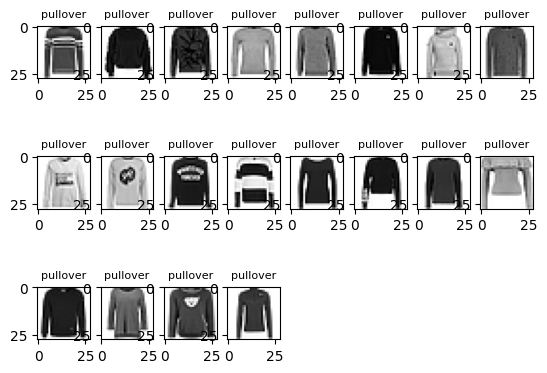

In [5]:
showImagePairs(pullover[0:20])

In [6]:
class Critic(nn.Module):
    def __init__(self, img_channels, features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, features, 
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.block(features, features * 2, 4, 2, 1),
            self.block(features * 2, features * 4, 4, 2, 1),
            self.block(features * 4, features * 8, 4, 2, 1),
            self.block(features * 8, features * 16, 4, 2, 1),  
            self.block(features * 16, features * 32, 4, 2, 1),            
            nn.Conv2d(features * 32, 1, kernel_size=4,
                      stride=2, padding=0))
    def block(self, in_channels, out_channels, 
              kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,
                kernel_size,stride,padding,bias=False,),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2))
    def forward(self, x):
        return self.net(x)

In [7]:
class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels, features):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.block(noise_channels, features *64, 4, 1, 0),
            self.block(features * 64, features * 32, 4, 2, 1),
            self.block(features * 32, features * 16, 4, 2, 1),
            self.block(features * 16, features * 8, 4, 2, 1),
            self.block(features * 8, features * 4, 4, 2, 1),            
            self.block(features * 4, features * 2, 4, 2, 1),            
            nn.ConvTranspose2d(
                features * 2, img_channels, kernel_size=4,
                stride=2, padding=1),
            nn.Tanh())
    def block(self, in_channels, out_channels, 
              kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,
                kernel_size,stride,padding,bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),)
    def forward(self, x):
        return self.net(x)

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)    

In [9]:
z_dim=50
img_channels=1
features=16
gen=Generator(z_dim+10,img_channels,features).to(device)
critic=Critic(img_channels+10,features).to(device)
weights_init(gen)
weights_init(critic)

In [10]:
lr = 0.0001
opt_gen = torch.optim.Adam(gen.parameters(), 
                         lr = lr, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), 
                         lr = lr, betas=(0.0, 0.9))

In [11]:
batch_size=16
imgsz=28
transform=T.Compose([
    T.Resize((imgsz,imgsz)),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])      
data_set=train_set

In [12]:
newdata=[]
for i,(img,label) in enumerate(data_set):
    onehot=torch.zeros((10))
    onehot[label]=1
    channels=torch.zeros((10,imgsz,imgsz))
    channels[label,:,:]=1    

    img_and_label=torch.cat([img,channels],dim=0)    
    newdata.append((img,label,onehot,img_and_label))

In [13]:
data_loader=torch.utils.data.DataLoader(
    newdata,batch_size=batch_size,shuffle=True)

In [14]:
onehots = []
for x in newdata[0: 16]:
    onehots.append(x[2])
    # onehots.append(onehot)

onehots = torch.stack(onehots)
onehots.shape
# noise = torch.randn(16, 50, 1, 1)
# noise
# onehots.reshape(-1, 10, 1, 1)
# _,_,onehots,img_and_labels = data_loader[0]
# onehots

torch.Size([16, 10])

In [19]:
def train_batch(onehots,img_and_labels,epoch):
    real = img_and_labels.to(device)
    B = real.shape[0]
    # train critic five times
    for _ in range(5):
        noise = torch.randn(B, z_dim, 1, 1)
        # print(onehots)
        onehots=onehots.reshape(-1,10,1, 1)
        noise_and_labels=torch.cat([noise,onehots],dim=1).to(device)
        fake_img = gen(noise_and_labels).to(device)
        fakelabels=img_and_labels[:,3:,:,:].to(device)
        print("NOISE", noise_and_labels.shape, noise_and_labels)
        print("FAKE_IMAGE", fake_img.shape, fake_img)
        print("FAKE_LABELS", fakelabels.shape, fakelabels)
        fake=torch.cat([fake_img,fakelabels],dim=1).to(device)
        critic_real = critic(real).reshape(-1)
        critic_fake = critic(fake).reshape(-1)
        gp = GP(critic, real, fake)
        loss_critic=(-(torch.mean(critic_real) - 
           torch.mean(critic_fake)) + 10 * gp)
        opt_critic.zero_grad()
        loss_critic.backward(retain_graph=True)
        opt_critic.step()
    # train G
    gen_fake = critic(fake).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    opt_gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    return loss_critic, loss_gen

In [20]:
def GP(critic, real, fake):
    B, C, H, W = real.shape
    alpha=torch.rand((B,1,1,1)).repeat(1,C,H,W).to(device)
    interpolated_images = real*alpha+fake*(1-alpha)
    critic_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=critic_scores,
        grad_outputs=torch.ones_like(critic_scores),
        create_graph=True,
        retain_graph=True)[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gp = torch.mean((gradient_norm - 1) ** 2)
    return gp

In [21]:
def plot_epoch(epoch):
    # test images with glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)
    # use label [1,0] so G knows what to generate
    labels[:,0,:,:]=1
    noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(20,10),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"files/glasses/G{epoch}.png")
    plt.show() 
    # test images without glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)
    # use label [0,1] so G knows what to generate
    labels[:,1,:,:]=1
    noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(20,10),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"files/glasses/NoG{epoch}.png")
    plt.show()     

In [22]:
for epoch in range(1,101):
    closs=0
    gloss=0
    for _,_,onehots,img_and_labels in data_loader:    
        # train a batch
        loss_critic, loss_gen = train_batch(onehots,\
                                img_and_labels,epoch)   
        closs+=loss_critic.detach()/len(data_loader)
        gloss+=loss_gen.detach()/len(data_loader)
    print(f"at epoch {epoch},\
    critic loss: {closs}, generator loss {gloss}")
    plot_epoch(epoch)
torch.save(gen.state_dict(),'files/cgan.pth')

NOISE torch.Size([16, 60, 1, 1]) tensor([[[[-4.0569e-01]],

         [[-1.5939e+00]],

         [[-2.4953e+00]],

         [[-1.6237e+00]],

         [[ 9.2342e-01]],

         [[ 1.8302e+00]],

         [[-1.9525e+00]],

         [[ 6.3428e-01]],

         [[ 7.1433e-01]],

         [[ 2.6864e+00]],

         [[-2.0419e-01]],

         [[ 1.1622e+00]],

         [[-2.1472e+00]],

         [[-3.5159e-02]],

         [[ 1.1051e+00]],

         [[-1.6011e-01]],

         [[ 6.0301e-01]],

         [[-1.4122e+00]],

         [[-1.0703e-01]],

         [[ 1.7675e+00]],

         [[ 8.9515e-01]],

         [[ 1.5008e+00]],

         [[-8.8333e-01]],

         [[-3.6511e-01]],

         [[-9.2681e-01]],

         [[-3.8991e-01]],

         [[-7.2508e-01]],

         [[ 2.4207e+00]],

         [[ 1.6452e+00]],

         [[-9.3993e-01]],

         [[ 6.9449e-01]],

         [[-4.1004e-01]],

         [[-5.7084e-01]],

         [[ 8.2108e-01]],

         [[ 2.6858e-01]],

         [[ 1.0654e+00

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 256 but got size 28 for tensor number 1 in the list.